# Walmart-style Multimodal Shopping Assistant Demo

Goal: given a **user image** (e.g., a Walmart cart/receipt/screenshot) and a **question**, detect which **product the customer likes**, extract **grounded features**, and recommend similar catalog items with explanations.

This notebook is designed to run locally with:

- OCR sidecar: `http://localhost:8010/ocr` (from this repo’s Docker Compose)
- Optional OpenAI vision/text: set `OPENAI_API_KEY` to improve extraction quality
- Optional Ninai backend: store the image as an attachment + inspect Qdrant payloads

Important: this demo includes guardrails to avoid inventing brands/features that aren’t present in either the image text (OCR) or the catalog.

In [1]:
# 1) Install & Import Dependencies
%pip install -q pandas numpy pillow pydantic requests tqdm scikit-learn pytest qdrant-client openai
%pip install -q -e ../sdk/python
print("Dependencies installed")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Dependencies installed


In [ ]:
import os
import re
import json
import uuid
from dataclasses import dataclass
from pathlib import Path
from typing import Any, Optional

import numpy as np
import pandas as pd
import requests
from PIL import Image, ImageDraw
from pydantic import BaseModel, Field
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display

DEMO_DIR = (Path.cwd() / "_demo_assets" / "walmart_multimodal_shopping_demo").resolve()
DEMO_DIR.mkdir(parents=True, exist_ok=True)

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OCR_SIDECAR_URL = os.getenv("OCR_SIDECAR_URL", "http://localhost:8010/ocr")
OCR_SIDECAR_HEALTH = os.getenv("OCR_SIDECAR_HEALTH", "http://localhost:8010/health")

print("Demo dir:", DEMO_DIR)
print("OCR sidecar:", OCR_SIDECAR_URL)
print("OpenAI enabled:", bool(OPENAI_API_KEY))

Demo dir: D:\Sansten\Projects\Ninai2\notebooks\_demo_assets\walmart_multimodal_shopping_demo
OCR sidecar: http://localhost:8010/ocr
OpenAI enabled: False


## 2) Load the User Image & Basic Preprocessing

You can either:
- point to your own image file, or
- generate a synthetic “receipt/cart screenshot” image for repeatable demos.

In [3]:
def load_image(path: str | Path) -> Image.Image:
    p = Path(path).expanduser().resolve()
    if not p.exists():
        raise FileNotFoundError(str(p))
    # EXIF-safe loading + consistent format
    img = Image.open(str(p))
    img = img.convert("RGB")
    return img


def save_resized(img: Image.Image, dest: Path, max_side: int = 1400, quality: int = 90) -> Path:
    dest.parent.mkdir(parents=True, exist_ok=True)
    w, h = img.size
    scale = min(1.0, max_side / max(w, h))
    if scale < 1.0:
        img = img.resize((int(w * scale), int(h * scale)))
    img.save(str(dest), format="JPEG", quality=quality)
    return dest


def generate_synthetic_receipt_image(dest: Path) -> Path:
    # A synthetic “receipt” screenshot with text that OCR can read.
    lines = [
        "Walmart - Order Summary",
        "----------------------",
        "1  Great Value Organic Almond Butter 16 oz   $7.48",
        "1  Silk Oatmilk Vanilla 64 fl oz             $4.28",
        "2  Bounty Paper Towels 6 ct                  $13.97",
        "",
        "Customer note:",
        "  I LOVE the organic almond butter - creamy, 16oz jar.",
        "",
        "Thank you for shopping!",
    ]
    img = Image.new("RGB", (1150, 650), color=(250, 250, 250))
    draw = ImageDraw.Draw(img)
    y = 30
    for line in lines:
        draw.text((35, y), line, fill=(15, 15, 15))
        y += 42
    img.save(str(dest), format="PNG")
    return dest


# Use your own image by setting USER_IMAGE_PATH. Otherwise generate a demo image.
USER_IMAGE_PATH = os.getenv("USER_IMAGE_PATH")
if USER_IMAGE_PATH:
    image_path = Path(USER_IMAGE_PATH).expanduser().resolve()
else:
    image_path = DEMO_DIR / "synthetic_receipt.png"
    generate_synthetic_receipt_image(image_path)


img = load_image(image_path)
img.size, image_path

((1150, 650),
 WindowsPath('D:/Sansten/Projects/Ninai2/notebooks/_demo_assets/walmart_multimodal_shopping_demo/synthetic_receipt.png'))

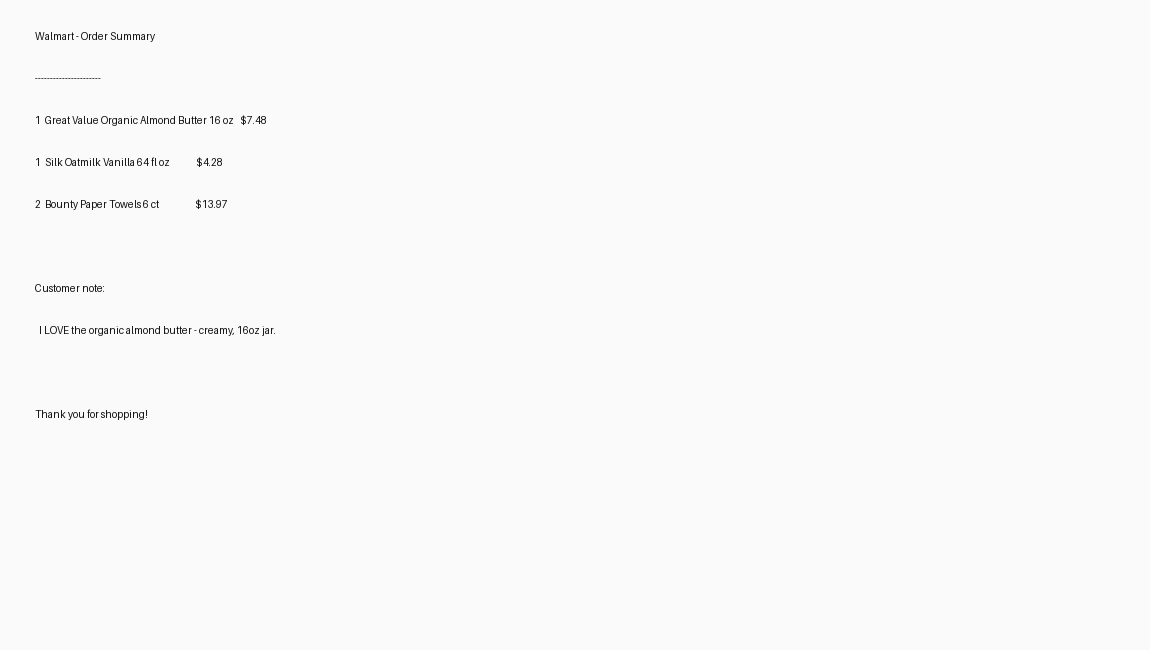

In [4]:
# Display image inline (Jupyter will render a PIL image)
img

## 3) Multimodal Product Understanding (Extract user-liked product + visual features)

We’ll do OCR-first grounding (so we can cite evidence from the image text).
If `OPENAI_API_KEY` is set, we’ll optionally use an LLM to improve parsing/feature extraction—but still constrain outputs to what’s supported by evidence.

In [16]:
def ocr_image(path: Path, *, url: str = OCR_SIDECAR_URL, timeout: float = 15.0) -> str:
    # Prefer the OCR sidecar (docker). Fallbacks are best-effort.
    try:
        requests.get(OCR_SIDECAR_HEALTH, timeout=3).raise_for_status()
        with open(path, "rb") as f:
            files = {"file": (path.name, f, "application/octet-stream")}
            r = requests.post(url, files=files, timeout=timeout)
            r.raise_for_status()
            return (r.json().get("text") or "").strip()
    except Exception as e:
        # Fallback: try local pytesseract if installed + tesseract present.
        try:
            import shutil
            if not shutil.which("tesseract"):
                raise RuntimeError("tesseract not found")
            import pytesseract  # type: ignore
            from PIL import Image as PILImage
            img_local = PILImage.open(str(path)).convert("RGB")
            return (pytesseract.image_to_string(img_local) or "").strip()
        except Exception as e2:
            raise RuntimeError(
                "OCR unavailable. Start docker compose (includes OCR), or set up local tesseract. "
                f"Sidecar error: {e}; local error: {e2}"
            )

def tokenize(s: str) -> set[str]:
    return {t for t in re.split(r"[^a-z0-9]+", (s or "").lower()) if t}

def extract_sizes_from_text(text: str) -> list[str]:
    # Normalize common size patterns like '16 oz', '16oz', '64 fl oz', '6 ct'.
    t = (text or "").lower()
    out: list[str] = []
    for m in re.finditer(r"(\d+(?:\.\d+)?)\s*(fl\s*oz|oz|lb|ct|count)\b", t):
        unit = re.sub(r"\s+", " ", m.group(2)).strip()
        out.append(f"{m.group(1)} {unit}")
    for m in re.finditer(r"(\d+)\s*oz\b", t):
        out.append(f"{m.group(1)} oz")
    for m in re.finditer(r"(\d+)\s*ct\b", t):
        out.append(f"{m.group(1)} ct")
    # Dedup preserving order
    seen = set()
    cleaned = []
    for s in out:
        if s not in seen:
            cleaned.append(s)
            seen.add(s)
    return cleaned

def parse_products_from_ocr(ocr_text: str) -> list[dict[str, Any]]:
    lines = [ln.strip() for ln in (ocr_text or "").splitlines() if ln.strip()]
    products: list[dict[str, Any]] = []
    # Heuristic: look for receipt-like lines that begin with a quantity.
    qty_re = re.compile(r"^(\d+)\s+(.+?)(\s+\$?\d+\.\d{2})?$", re.IGNORECASE)
    for ln in lines:
        m = qty_re.match(ln)
        if not m:
            continue
        qty = int(m.group(1))
        rest = m.group(2).strip()
        price = None
        if m.group(3):
            try:
                price = float(m.group(3).replace("$", "").strip())
            except Exception:
                price = None
        products.append({"qty": qty, "raw": ln, "title": rest, "price": price})
    return products

def extract_features(title: str, *, context_text: str) -> dict[str, Any]:
    t = (title or "").strip()
    context = (context_text or "").strip()
    tokens = tokenize(t)
    context_tokens = tokenize(context)

    sizes = extract_sizes_from_text(t)
    for s in extract_sizes_from_text(context):
        if s not in sizes:
            sizes.append(s)

    known_attrs = ["organic", "vanilla", "creamy", "gluten", "free", "wireless", "insulated", "reusable"]
    attrs = [a for a in known_attrs if a in tokens or a in context_tokens]

    # Brand heuristic (best-effort, not guaranteed): first two words from the title.
    words = [w for w in re.split(r"\s+", t) if w]
    brand = " ".join(words[:2]) if len(words) >= 2 else (words[0] if words else None)
    return {"brand_guess": brand, "sizes": sizes, "attrs": attrs}

def pick_liked_product(products: list[dict[str, Any]], question: str, ocr_text: str) -> Optional[dict[str, Any]]:
    # 1) If question mentions a product keyword, select best title match.
    q_tokens = tokenize(question)
    best = None
    best_score = 0.0
    for p in products:
        title_tokens = tokenize(p.get("title", ""))
        score = len(q_tokens & title_tokens) / max(1, len(q_tokens))
        if score > best_score:
            best_score = score
            best = p
    if best and best_score >= 0.15:
        return {**best, "match_reason": "question_token_overlap", "match_score": best_score}

    # 2) If OCR text has a "Customer note"-style hint, use it.
    note_lines = [ln for ln in (ocr_text or "").splitlines() if "love" in ln.lower() or "like" in ln.lower()]
    if note_lines:
        note = " ".join(note_lines)
        note_tokens = tokenize(note)
        best = None
        best_score = 0.0
        for p in products:
            title_tokens = tokenize(p.get("title", ""))
            score = len(note_tokens & title_tokens) / max(1, len(note_tokens))
            if score > best_score:
                best_score = score
                best = p
        if best and best_score >= 0.10:
            return {**best, "note_context": note, "match_reason": "customer_note_overlap", "match_score": best_score}

    # 3) Fallback: first product line.
    return products[0] if products else None

def multimodal_extract(image_path: Path, question: str) -> dict[str, Any]:
    ocr_text = ocr_image(image_path)
    products = parse_products_from_ocr(ocr_text)
    liked = pick_liked_product(products, question, ocr_text)
    liked_title = (liked or {}).get("title")

    context_text = ""
    if liked:
        context_text = "\n".join([str(liked.get("raw") or ""), str(liked.get("note_context") or "")]).strip()

    features = extract_features(liked_title, context_text=context_text) if liked_title else {}

    result = {
        "question": question,
        "ocr_text": ocr_text,
        "products": products,
        "liked_product": liked,
        "liked_features": features,
        "confidence": 0.75 if liked else 0.2,
        "evidence": {"liked_product_line": (liked or {}).get("raw")},
    }

    # Optional: use OpenAI to refine ONLY using evidence (OCR text).
    if OPENAI_API_KEY:
        try:
            from openai import OpenAI
            llm = OpenAI(api_key=OPENAI_API_KEY)
            prompt = {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": (
                            "You are helping extract a liked product from OCR text of a Walmart-style receipt/cart.\n\n"
                            "Rules:\n"
                            "- Only use facts present in the OCR text below.\n"
                            "- Do NOT invent brands, sizes, flavors, or features.\n"
                            "- Output JSON with fields: liked_product_title, must_have_features, nice_to_have_features, avoid_features, evidence_quotes (array of OCR lines).\n\n"
                            "OCR TEXT:\n" + ocr_text + "\n\n"
                            "QUESTION:\n" + question
                        ),
                    }
                ],
            }
            resp = llm.chat.completions.create(
                model=os.getenv("OPENAI_MODEL", "gpt-4o-mini"),
                messages=[prompt],
                response_format={"type": "json_object"},
                temperature=0.2,
            )
            refined = json.loads(resp.choices[0].message.content)
            result["llm_refined"] = refined
        except Exception as e:
            result["llm_refined_error"] = str(e)[:300]

    return result

user_question = os.getenv("USER_QUESTION", "From this image, which product does the customer like? List key features.")
extraction = multimodal_extract(image_path, user_question)
print("Parsed products:", len(extraction["products"]))
print("Liked product:", (extraction.get("liked_product") or {}).get("title"))
print("Extracted attrs:", (extraction.get("liked_features") or {}).get("attrs"))
print("Extracted sizes:", (extraction.get("liked_features") or {}).get("sizes"))

Parsed products: 3
Liked product: Great Value Organic Almond Butter 18.02
Extracted attrs: ['organic', 'creamy']
Extracted sizes: []


## 4) Normalize Features into a Structured Schema (JSON)

We’ll normalize the extraction into a strict schema that downstream ranking uses.

In [17]:
class ProductPreference(BaseModel):
    category: str = Field(default="grocery")
    must_have_features: list[str] = Field(default_factory=list)
    nice_to_have_features: list[str] = Field(default_factory=list)
    colors: list[str] = Field(default_factory=list)
    materials: list[str] = Field(default_factory=list)
    price_range: Optional[tuple[float, float]] = None
    avoid_features: list[str] = Field(default_factory=list)
    confidence: float = Field(default=0.5, ge=0.0, le=1.0)
    evidence_quotes: list[str] = Field(default_factory=list)

def normalize_preference(extraction: dict[str, Any]) -> ProductPreference:
    liked = extraction.get("liked_product") or {}
    title = liked.get("title") or ""
    features = extraction.get("liked_features") or {}
    ocr_text = extraction.get("ocr_text") or ""

    must: list[str] = []
    # Grounded must-haves from OCR-derived features
    for a in (features.get("attrs") or []):
        if a and a.lower() not in {"free"}:
            must.append(a.lower())
    for s in (features.get("sizes") or []):
        if s:
            must.append(str(s).lower())

    evidence = []
    if extraction.get("evidence", {}).get("liked_product_line"):
        evidence.append(extraction["evidence"]["liked_product_line"])

    # If LLM refinement is available, still gate it: keep only features that appear in OCR text.
    if "llm_refined" in extraction:
        ref = extraction.get("llm_refined") or {}
        for feat in ref.get("must_have_features", []) or []:
            if feat and feat.lower() in ocr_text.lower():
                must.append(feat.lower())
        for q in ref.get("evidence_quotes", []) or []:
            if q and q.strip() in ocr_text:
                evidence.append(q.strip())

    # Basic category guess: map by keywords
    cat = "grocery"
    if any(k in tokenize(title) for k in ["towels", "paper"]):
        cat = "household"

    pref = ProductPreference(
        category=cat,
        must_have_features=sorted(set(must)),
        nice_to_have_features=[],
        colors=[],
        materials=[],
        price_range=None,
        avoid_features=[],
        confidence=float(extraction.get("confidence", 0.5)),
        evidence_quotes=evidence,
    )
    return pref

preference = normalize_preference(extraction)
preference.model_dump()

{'category': 'grocery',
 'must_have_features': ['creamy', 'organic'],
 'nice_to_have_features': [],
 'colors': [],
 'materials': [],
 'price_range': None,
 'avoid_features': [],
 'confidence': 0.75,
 'evidence_quotes': ['1 Great Value Organic Almond Butter 18.02 $7.48']}

## 5) Create a Walmart-like Product Catalog (Mock DataFrame + Metadata)

This is synthetic mock data (replace with a real catalog export/API later).

In [7]:
rng = np.random.default_rng(42)


def make_catalog() -> pd.DataFrame:
    rows = [
        {
            "sku": "SKU-ALM-001",
            "title": "Great Value Organic Almond Butter 16 oz",
            "description": "Organic almond butter. Smooth and creamy.",
            "category": "grocery",
            "features": ["organic", "almond butter", "16 oz"],
            "price": 7.48,
            "rating": 4.6,
            "availability": "in_stock",
        },
        {
            "sku": "SKU-ALM-002",
            "title": "Justin's Classic Almond Butter 16 oz",
            "description": "Premium almond butter with simple ingredients.",
            "category": "grocery",
            "features": ["almond butter", "16 oz"],
            "price": 11.97,
            "rating": 4.7,
            "availability": "in_stock",
        },
        {
            "sku": "SKU-PB-001",
            "title": "Great Value Creamy Peanut Butter 18 oz",
            "description": "Creamy peanut butter for sandwiches and smoothies.",
            "category": "grocery",
            "features": ["peanut butter", "creamy", "18 oz"],
            "price": 3.42,
            "rating": 4.5,
            "availability": "in_stock",
        },
        {
            "sku": "SKU-OAT-001",
            "title": "Silk Oatmilk Vanilla 64 fl oz",
            "description": "Vanilla oatmilk. Dairy-free alternative.",
            "category": "grocery",
            "features": ["oatmilk", "vanilla", "64 fl oz"],
            "price": 4.28,
            "rating": 4.4,
            "availability": "in_stock",
        },
        {
            "sku": "SKU-TWL-001",
            "title": "Bounty Paper Towels 6 ct",
            "description": "Strong absorbent paper towels.",
            "category": "household",
            "features": ["paper towels", "6 ct"],
            "price": 13.97,
            "rating": 4.8,
            "availability": "in_stock",
        },
    ]


    # Add more realistic filler items
    pantry = [
        ("SKU-CRM-001", "Great Value Greek Yogurt Strawberry 32 oz", ["yogurt", "strawberry", "32 oz"], 5.12, "grocery"),
        ("SKU-CRM-002", "Chobani Greek Yogurt Vanilla 32 oz", ["yogurt", "vanilla", "32 oz"], 6.24, "grocery"),
        ("SKU-SNK-001", "Kind Bars Almond & Coconut 12 ct", ["snack bar", "almond", "12 ct"], 14.48, "grocery"),
        ("SKU-SNK-002", "Great Value Trail Mix 30 oz", ["trail mix", "30 oz"], 7.92, "grocery"),
        ("SKU-DRK-001", "LaCroix Sparkling Water Variety 12 ct", ["sparkling water", "12 ct"], 5.98, "grocery"),
    ]
    for sku, title, feats, price, cat in pantry:
        rows.append({
            "sku": sku,
            "title": title,
            "description": f"{title}.",
            "category": cat,
            "features": feats,
            "price": float(price),
            "rating": float(rng.uniform(3.8, 4.9)),
            "availability": "in_stock",
        })


    return pd.DataFrame(rows)


catalog = make_catalog()
catalog.head(10)

,sku,title,description,category,features,price,rating,availability
0,SKU-ALM-001,Great Value Organic Almond Butter 16 oz,Organic almond butter. Smooth and creamy.,grocery,"[organic, almond butter, 16 oz]",7.48,4.600000,in_stock
1,SKU-ALM-002,Justin's Classic Almond Butter 16 oz,Premium almond butter with simple ingredients.,grocery,"[almond butter, 16 oz]",11.97,4.700000,in_stock
2,SKU-PB-001,Great Value Creamy Peanut Butter 18 oz,Creamy peanut butter for sandwiches and smooth...,grocery,"[peanut butter, creamy, 18 oz]",3.42,4.500000,in_stock
3,SKU-OAT-001,Silk Oatmilk Vanilla 64 fl oz,Vanilla oatmilk. Dairy-free alternative.,grocery,"[oatmilk, vanilla, 64 fl oz]",4.28,4.400000,in_stock
4,SKU-TWL-001,Bounty Paper Towels 6 ct,Strong absorbent paper towels.,household,"[paper towels, 6 ct]",13.97,4.800000,in_stock
5,SKU-CRM-001,Great Value Greek Yogurt Strawberry 32 oz,Great Value Greek Yogurt Strawberry 32 oz.,grocery,"[yogurt, strawberry, 32 oz]",5.12,4.651352,in_stock
6,SKU-CRM-002,Chobani Greek Yogurt Vanilla 32 oz,Chobani Greek Yogurt Vanilla 32 oz.,grocery,"[yogurt, vanilla, 32 oz]",6.24,4.282766,in_stock
7,SKU-SNK-001,Kind Bars Almond & Coconut 12 ct,Kind Bars Almond & Coconut 12 ct.,grocery,"[snack bar, almond, 12 ct]",14.48,4.744458,in_stock
8,SKU-SNK-002,Great Value Trail Mix 30 oz,Great Value Trail Mix 30 oz.,grocery,"[trail mix, 30 oz]",7.92,4.567105,in_stock
9,SKU-DRK-001,LaCroix Sparkling Water Variety 12 ct,LaCroix Sparkling Water Variety 12 ct.,grocery,"[sparkling water, 12 ct]",5.98,3.903595,in_stock


## 6) Text + Image Embeddings for Catalog Items

To keep this notebook runnable offline, we default to TF‑IDF text embeddings. If you have OpenAI enabled, you can swap in embedding APIs.

We cache embeddings to disk for repeat runs.

In [8]:
def item_to_text(row: pd.Series) -> str:
    feats = " ".join(row["features"]) if isinstance(row["features"], list) else str(row["features"])
    return f"{row['title']}\n{row['description']}\nCategory: {row['category']}\nFeatures: {feats}"


def embed_texts_tfidf(texts: list[str], *, cache_dir: Path) -> tuple[TfidfVectorizer, Any]:
    cache_dir.mkdir(parents=True, exist_ok=True)
    vec_path = cache_dir / "tfidf_vectorizer.json"
    mat_path = cache_dir / "tfidf_matrix.npy"


    # Simple caching: if sizes match, reuse.
    if vec_path.exists() and mat_path.exists():
        try:
            vec_data = json.loads(vec_path.read_text(encoding="utf-8"))
            vectorizer = TfidfVectorizer(**vec_data["params"])
            vectorizer.vocabulary_ = vec_data["vocabulary"]
            vectorizer.idf_ = np.array(vec_data["idf"], dtype=float)
            vectorizer._tfidf._idf_diag = None  # rebuild lazily
            mat = np.load(mat_path, allow_pickle=False)
            if mat.shape[0] == len(texts):
                return vectorizer, mat
        except Exception:
            pass


    vectorizer = TfidfVectorizer(stop_words="english")
    X = vectorizer.fit_transform(texts)
    mat = X.toarray().astype(np.float32)


    vec_path.write_text(
        json.dumps({
            "params": {"stop_words": "english"},
            "vocabulary": vectorizer.vocabulary_,
            "idf": vectorizer.idf_.tolist(),
        }),
        encoding="utf-8",
    )
    np.save(mat_path, mat, allow_pickle=False)
    return vectorizer, mat


CACHE_DIR = DEMO_DIR / "cache"
catalog_texts = [item_to_text(r) for _, r in catalog.iterrows()]
tfidf_vectorizer, catalog_embeddings = embed_texts_tfidf(catalog_texts, cache_dir=CACHE_DIR)
print("Catalog embeddings shape:", catalog_embeddings.shape)

Catalog embeddings shape: (10, 54)


## 7) Similarity Scoring & Ranking (Feature match + embedding match)

We combine TF‑IDF cosine similarity with a structured feature match score:

$$s = \alpha\,\cos(e_u, e_i) + (1-\alpha)\,m(f_u, f_i)$$

In [9]:
def normalize_feature(s: str) -> str:
    return re.sub(r"\s+", " ", (s or "").strip().lower())


def feature_match_score(pref: ProductPreference, item_features: list[str]) -> float:
    feats = {normalize_feature(f) for f in (item_features or [])}
    must = {normalize_feature(f) for f in pref.must_have_features}
    avoid = {normalize_feature(f) for f in pref.avoid_features}


    if must:
        overlap = len(must & feats)
        base = overlap / max(1, len(must))
    else:
        base = 0.0


    penalty = 0.0
    if avoid and feats:
        penalty = len(avoid & feats) / max(1, len(avoid))


    return max(0.0, base - penalty)


def embed_user_query(pref: ProductPreference, liked_title: str) -> np.ndarray:
    # User embedding uses the same TF-IDF vectorizer as the catalog.
    q = liked_title
    if pref.must_have_features:
        q += "\nMust: " + ", ".join(pref.must_have_features)
    if pref.category:
        q += "\nCategory: " + pref.category
    X = tfidf_vectorizer.transform([q]).toarray().astype(np.float32)
    return X[0]


def rank_catalog(
    catalog: pd.DataFrame,
    catalog_embeddings: np.ndarray,
    pref: ProductPreference,
    extraction: dict[str, Any],
    *,
    alpha: float = 0.65,
    top_k: int = 5,
    max_price: Optional[float] = None,
    category_filter: Optional[str] = None,
 ) -> pd.DataFrame:
    liked_title = ((extraction.get("liked_product") or {}).get("title") or "")
    user_vec = embed_user_query(pref, liked_title)
    cos = cosine_similarity([user_vec], catalog_embeddings)[0]


    scores = []
    for idx, row in catalog.iterrows():
        if category_filter and row["category"] != category_filter:
            scores.append(-1.0)
            continue
        if max_price is not None and float(row["price"]) > float(max_price):
            scores.append(-1.0)
            continue
        m = feature_match_score(pref, row["features"])
        s = alpha * float(cos[idx]) + (1 - alpha) * float(m)
        scores.append(s)


    out = catalog.copy()
    out["score"] = scores
    out = out.sort_values("score", ascending=False).head(top_k)
    return out


top = rank_catalog(catalog, catalog_embeddings, preference, extraction, top_k=5, category_filter=preference.category)
top[["sku", "title", "price", "rating", "score", "features"]]

,sku,title,price,rating,score,features
0,SKU-ALM-001,Great Value Organic Almond Butter 16 oz,7.48,4.600000,0.847354,"[organic, almond butter, 16 oz]"
2,SKU-PB-001,Great Value Creamy Peanut Butter 18 oz,3.42,4.500000,0.217212,"[peanut butter, creamy, 18 oz]"
1,SKU-ALM-002,Justin's Classic Almond Butter 16 oz,11.97,4.700000,0.198796,"[almond butter, 16 oz]"
5,SKU-CRM-001,Great Value Greek Yogurt Strawberry 32 oz,5.12,4.651352,0.088713,"[yogurt, strawberry, 32 oz]"
8,SKU-SNK-002,Great Value Trail Mix 30 oz,7.92,4.567105,0.085848,"[trail mix, 30 oz]"


## 8) Generate Recommendations with Explanations (Why this matches the image)

Explanations are grounded only in:
- extracted must-have features (from OCR evidence), and
- catalog item fields/features.

In [10]:
def explain_match(pref: ProductPreference, row: pd.Series, extraction: dict[str, Any]) -> str:
    feats = {normalize_feature(f) for f in (row.get("features") or [])}
    must = [normalize_feature(f) for f in pref.must_have_features]
    matched = [f for f in must if f in feats]


    liked_line = (extraction.get("evidence") or {}).get("liked_product_line")
    parts = []
    if matched:
        parts.append("Matches: " + ", ".join(matched))
    if liked_line:
        parts.append("Evidence: " + liked_line)
    parts.append(f"Price ${row['price']:.2f}, rating {row['rating']:.1f}")
    return " | ".join(parts)


top = rank_catalog(catalog, catalog_embeddings, preference, extraction, top_k=5, category_filter=preference.category)
top = top.assign(explanation=[explain_match(preference, r, extraction) for _, r in top.iterrows()])
top[["sku", "title", "price", "score", "explanation"]]

,sku,title,price,score,explanation
0,SKU-ALM-001,Great Value Organic Almond Butter 16 oz,7.48,0.847354,Matches: organic | Evidence: 1 Great Value Org...
2,SKU-PB-001,Great Value Creamy Peanut Butter 18 oz,3.42,0.217212,Evidence: 1 Great Value Organic Almond Butter ...
1,SKU-ALM-002,Justin's Classic Almond Butter 16 oz,11.97,0.198796,Evidence: 1 Great Value Organic Almond Butter ...
5,SKU-CRM-001,Great Value Greek Yogurt Strawberry 32 oz,5.12,0.088713,Evidence: 1 Great Value Organic Almond Butter ...
8,SKU-SNK-002,Great Value Trail Mix 30 oz,7.92,0.085848,Evidence: 1 Great Value Organic Almond Butter ...


## 9) Conversational Q&A Loop (User follow-ups, constraints, refinements)

We’ll simulate follow-ups like “cheaper” or “only organic” by updating constraints and re-ranking.

In [11]:
@dataclass
class SessionState:
    pref: ProductPreference
    max_price: Optional[float] = None
    category_filter: Optional[str] = None


def apply_refinement(state: SessionState, text: str) -> SessionState:
    t = (text or "").lower().strip()
    if not t:
        return state


    if "cheaper" in t or "less" in t:
        # naive: cut max price to current best price
        state.max_price = (state.max_price or float("inf"))
        state.max_price = min(state.max_price, 8.00)
    if "only organic" in t or "organic" == t:
        state.pref.must_have_features = sorted(set(state.pref.must_have_features + ["organic"]))
    m = re.search(r"under\s*\$?(\d+(?:\.\d+)?)", t)
    if m:
        state.max_price = float(m.group(1))


    return state


state = SessionState(pref=preference, category_filter=preference.category)


for msg in ["cheaper", "only organic", "under $10"]:
    state = apply_refinement(state, msg)
    recs = rank_catalog(
        catalog,
        catalog_embeddings,
        state.pref,
        extraction,
        top_k=5,
        max_price=state.max_price,
        category_filter=state.category_filter,
    )
    print("\nUser refinement:", msg)
    print("max_price:", state.max_price, "must_have:", state.pref.must_have_features)
    display(recs[["sku", "title", "price", "score"]])


User refinement: cheaper
max_price: 8.0 must_have: ['organic']


,sku,title,price,score
0,SKU-ALM-001,Great Value Organic Almond Butter 16 oz,7.48,0.847354
2,SKU-PB-001,Great Value Creamy Peanut Butter 18 oz,3.42,0.217212
5,SKU-CRM-001,Great Value Greek Yogurt Strawberry 32 oz,5.12,0.088713
8,SKU-SNK-002,Great Value Trail Mix 30 oz,7.92,0.085848
3,SKU-OAT-001,Silk Oatmilk Vanilla 64 fl oz,4.28,0.013475



User refinement: only organic
max_price: 8.0 must_have: ['organic']


,sku,title,price,score
0,SKU-ALM-001,Great Value Organic Almond Butter 16 oz,7.48,0.847354
2,SKU-PB-001,Great Value Creamy Peanut Butter 18 oz,3.42,0.217212
5,SKU-CRM-001,Great Value Greek Yogurt Strawberry 32 oz,5.12,0.088713
8,SKU-SNK-002,Great Value Trail Mix 30 oz,7.92,0.085848
3,SKU-OAT-001,Silk Oatmilk Vanilla 64 fl oz,4.28,0.013475



User refinement: under $10
max_price: 10.0 must_have: ['organic']


,sku,title,price,score
0,SKU-ALM-001,Great Value Organic Almond Butter 16 oz,7.48,0.847354
2,SKU-PB-001,Great Value Creamy Peanut Butter 18 oz,3.42,0.217212
5,SKU-CRM-001,Great Value Greek Yogurt Strawberry 32 oz,5.12,0.088713
8,SKU-SNK-002,Great Value Trail Mix 30 oz,7.92,0.085848
3,SKU-OAT-001,Silk Oatmilk Vanilla 64 fl oz,4.28,0.013475


## 10) Guardrails & Validation (schema checks, missing data, unsafe outputs)

If OCR fails or confidence is low, we fall back to returning candidates and asking a clarifying question rather than guessing.

In [12]:
def guarded_answer(extraction: dict[str, Any], pref: ProductPreference) -> dict[str, Any]:
    products = extraction.get("products") or []
    liked = extraction.get("liked_product") or None
    if not products:
        return {
            "answer": "I couldn't read any products from the image. Can you upload a clearer image or a screenshot with readable text?",
            "confidence": 0.0,
            "candidates": [],
        }


    if not liked or pref.confidence < 0.4:
        candidates = [p.get("title") for p in products[:5]]
        return {
            "answer": "I see multiple products but I'm not confident which one you mean. Which one do you like?",
            "confidence": float(pref.confidence),
            "candidates": candidates,
        }


    title = liked.get("title")
    return {
        "answer": f"You seem to like: {title}. Key features: {pref.must_have_features}",
        "confidence": float(pref.confidence),
        "evidence": pref.evidence_quotes,
    }


guarded_answer(extraction, preference)

{'answer': "You seem to like: Great Value Organic Almond Butter 18.02. Key features: ['organic']",
 'confidence': 0.75,
 'evidence': ['1 Great Value Organic Almond Butter 18.02 $7.48']}

## 11) Offline Evaluation (top‑k accuracy on a small labeled set)

We’ll generate a tiny labeled set of synthetic receipt images (known target SKU) and report top‑1/top‑5 hit rate.

In [13]:
def generate_labeled_receipt(dest: Path, liked_line: str, note: str) -> Path:
    lines = [
        "Walmart - Order Summary",
        "----------------------",
        liked_line,
        "1  Some Other Item 12 ct                 $9.99",
        "",
        "Customer note:",
        "  " + note,
    ]
    img = Image.new("RGB", (1150, 520), color=(250, 250, 250))
    draw = ImageDraw.Draw(img)
    y = 30
    for line in lines:
        draw.text((35, y), line, fill=(15, 15, 15))
        y += 42
    img.save(str(dest), format="PNG")
    return dest


eval_cases = [
    {
        "path": DEMO_DIR / "eval_almond.png",
        "question": "Which product do I like? List features.",
        "liked_line": "1  Great Value Organic Almond Butter 16 oz   $7.48",
        "note": "I LOVE the organic almond butter - 16oz.",
        "expected_sku": "SKU-ALM-001",
    },
    {
        "path": DEMO_DIR / "eval_oatmilk.png",
        "question": "What product do I like from this cart?",
        "liked_line": "1  Silk Oatmilk Vanilla 64 fl oz             $4.28",
        "note": "I like the vanilla oatmilk (64 fl oz).",
        "expected_sku": "SKU-OAT-001",
    },
]


for c in eval_cases:
    generate_labeled_receipt(c["path"], c["liked_line"], c["note"])


def evaluate_case(case: dict[str, Any], k: int = 5) -> dict[str, Any]:
    ext = multimodal_extract(case["path"], case["question"])
    pref = normalize_preference(ext)
    recs = rank_catalog(catalog, catalog_embeddings, pref, ext, top_k=k, category_filter=pref.category)
    got = list(recs["sku"])
    return {
        "case": case["path"].name,
        "expected": case["expected_sku"],
        "top1": got[0] if got else None,
        "hit@1": int(bool(got) and got[0] == case["expected_sku"]),
        "hit@5": int(case["expected_sku"] in got),
        "liked_title": (ext.get("liked_product") or {}).get("title"),
    }


rows = [evaluate_case(c, k=5) for c in eval_cases]
pd.DataFrame(rows)

,case,expected,top1,hit@1,hit@5,liked_title
0,eval_almond.png,SKU-ALM-001,SKU-ALM-001,1,1,Great Value Organic Almond Butter 18.02
1,eval_oatmilk.png,SKU-OAT-001,SKU-ALM-002,0,1,SilkOatmitk Vanils64tloz $428


## 12) VS Code-Friendly Unit Tests (pytest) for extract/rank/explain

This cell writes a tiny helper module + tests, then runs `pytest -q`.

In [19]:
import sys
import textwrap
import subprocess

# Write the helper + tests into the repo-level notebooks/ folder (not notebooks/notebooks/).
repo_root = Path.cwd().resolve()
if repo_root.name.lower() == "notebooks":
    repo_root = repo_root.parent

lib_path = repo_root / "notebooks" / "_walmart_demo_lib.py"
tests_dir = repo_root / "notebooks" / "_walmart_demo_tests"
tests_dir.mkdir(parents=True, exist_ok=True)
test_path = tests_dir / "test_walmart_demo.py"

lib_path.write_text(
    textwrap.dedent(r"""
    import re
    from dataclasses import dataclass


    def normalize_feature(s: str) -> str:
        return re.sub(r"\s+", " ", (s or "").strip().lower())


    @dataclass
    class Pref:
        must_have_features: list[str]
        avoid_features: list[str]


    def feature_match_score(pref: Pref, item_features: list[str]) -> float:
        feats = {normalize_feature(f) for f in (item_features or [])}
        must = {normalize_feature(f) for f in pref.must_have_features}
        avoid = {normalize_feature(f) for f in pref.avoid_features}
        base = (len(must & feats) / max(1, len(must))) if must else 0.0
        penalty = (len(avoid & feats) / max(1, len(avoid))) if avoid else 0.0
        return max(0.0, base - penalty)
    """),
    encoding="utf-8",
 )

test_path.write_text(
    textwrap.dedent(r"""
    from notebooks._walmart_demo_lib import Pref, feature_match_score


    def test_feature_match_score_basic():
        pref = Pref(must_have_features=["organic", "16 oz"], avoid_features=[])
        score = feature_match_score(pref, ["organic", "almond butter", "16 oz"])
        assert score == 1.0


    def test_feature_match_score_penalty():
        pref = Pref(must_have_features=["organic"], avoid_features=["vanilla"])
        score = feature_match_score(pref, ["organic", "vanilla"])
        assert score == 0.0
    """),
    encoding="utf-8",
 )

print("Wrote:", lib_path)
print("Wrote:", test_path)

# Run pytest from repo root so `import notebooks.*` resolves consistently.
cmd = [sys.executable, "-m", "pytest", str(tests_dir), "-q"]
proc = subprocess.run(cmd, capture_output=True, text=True, cwd=str(repo_root))
print(proc.stdout)
print(proc.stderr)
proc.returncode

Wrote: D:\Sansten\Projects\Ninai2\notebooks\_walmart_demo_lib.py
Wrote: D:\Sansten\Projects\Ninai2\notebooks\_walmart_demo_tests\test_walmart_demo.py
..                                                                       [100%]
2 passed in 0.07s




0

## Optional: Store the image + preference in Ninai (attachments) and inspect Qdrant

This shows how to upload the image as a Ninai attachment and check its `indexed_at`.
Then (optionally) retrieve the attachment vector payload directly from Qdrant using the attachment id.

In [ ]:
# Skip this cell if you don't have Ninai backend running/auth set up.
from ninai import NinaiClient
from getpass import getpass


API_URL = os.getenv("NINAI_API_URL", "http://localhost:8000/api/v1")
API_KEY = os.getenv("NINAI_API_KEY")
ORG_ID = os.getenv("NINAI_ORGANIZATION_ID")


ninai = NinaiClient(base_url=API_URL, api_key=API_KEY, organization_id=ORG_ID)
if not ninai.is_authenticated:
    email = input("Email: ").strip()
    password = getpass("Password: ")
    ninai.login(email=email, password=password)


memory = ninai.memories.create(
    title=f"Walmart multimodal demo ({uuid.uuid4().hex[:8]})",
    content=json.dumps({
        "question": extraction["question"],
        "liked_product": extraction.get("liked_product"),
        "preference": preference.model_dump(),
        "top_recommendations": top[["sku", "title", "price", "score"]].to_dict(orient="records"),
    }, indent=2),
    tags=["demo", "walmart", "multimodal"],
    scope="personal",
    memory_type="long_term",
    classification="internal",
)
print("Created memory:", memory.id)


upload_resp = ninai.memories.upload_attachment(memory.id, str(image_path))
attachment_id = upload_resp.get("id")
print("Uploaded attachment id:", attachment_id)


atts = ninai.memories.list_attachments(memory.id)
print("Attachment status:")
for a in atts.get("items", []):
    print("-", a.get("file_name"), "indexed_at=", a.get("indexed_at"), "content_type=", a.get("content_type"))


# Optional: inspect Qdrant payload for the attachment point
try:
    from qdrant_client import QdrantClient
    qc = QdrantClient(host=os.getenv("QDRANT_HOST", "localhost"), port=int(os.getenv("QDRANT_PORT", "6333")))
    collection = os.getenv("QDRANT_COLLECTION_NAME", "memories")
    if attachment_id:
        pts = qc.retrieve(collection_name=collection, ids=[attachment_id], with_payload=True, with_vectors=False)
        if pts:
            print("Qdrant payload:")
            print(json.dumps(pts[0].payload, indent=2, default=str))
except Exception as e:
    print("(Skipping Qdrant inspection)", str(e)[:200])